# Reading ASTI AWS netcdf data

Author: [Irene Crisologo](http://philippineradarnetwork.wordpress.com/)

This notebook shows how to read the extracted netcdf files and generate a Pandas dataframe from the contents. A few examples of how to work with the Pandas dataframe are shown below, as well as examples on how to plot the data.

#### Import necessary modules
Here we need [numpy](www.numpy.org/) to handle arrays, [Pandas](pandas.pydata.org/) for making a structured dataset, [netCDF4](unidata.github.io/netcdf4-python/) for reading the netcdf files, [datetime](https://docs.python.org/2/library/datetime.html) for handling date and time objects, and pylab for plotting.

In [1]:
%matplotlib inline 
# above is an iPython magic command that displays plots immediately after the cell where the plot was made
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import pylab as pl

Set the path of the file we want to read.

In [2]:
fname = '../dataset/agws.01m.v1.201311.nc'

Read the netcdf file.

In [3]:
dset = nc.Dataset(fname)

Display all the variables contained in the file, as well as the length of each variable.

In [4]:
for variable_name in dset.variables.keys():
    print variable_name, len(dset[variable_name][...])

station_id 703
station_location 703
station_municipality 703
station_province 703
station_region 703
station_type 703
sampling_period 703
lat 703
lon 703
alt 703
stationIndex 2026845
timestamp 2026845
relative_humidity 2026845
relative_humidity_qc 2026845
surface_air_pressure 2026845
surface_air_pressure_qc 2026845
air_temperature 2026845
air_temperature_qc 2026845
dew_point 2026845
dew_point_qc 2026845
ground_water_pressure 2026845
ground_water_pressure_qc 2026845
ground_water_temperature 2026845
ground_water_temperature_qc 2026845
leaf_wetness 2026845
leaf_wetness_qc 2026845
total_rainfall_amount 2026845
total_rainfall_amount_qc 2026845
rainfall_duration 2026845
rainfall_duration_qc 2026845
rainfall_rate 2026845
rainfall_rate_qc 2026845
rainfall_amount 2026845
rainfall_amount_qc 2026845
soil_moisture_content_15cm 2026845
soil_moisture_content_15cm_qc 2026845
soil_moisture_content_30cm 2026845
soil_moisture_content_30cm_qc 2026845
soil_moisture_content_45cm 2026845
soil_moisture_conte

The list above means that the first ten variables are the metadata, where the number of stations within the file corresponds to the number printed beside it. The succeeding variables are the dataset variables.

Separate metadata from data.

In [5]:
metadata_keys = dset.variables.keys()[:10]

In [6]:
# get all, or portion of the dataset
#data_keys = dset.variables.keys()[10:]

# or specify the variables you want to extract
data_keys = ['rainfall_amount','rainfall_amount_qc','surface_air_pressure','surface_air_pressure_qc']

### Attributes

Initialize the dataframe where the attributes will be stored. The index is set to be the `station_id` variable, as this is unique for every entry.

In [7]:
metadata = pd.DataFrame(index=dset['station_id'][...], columns=metadata_keys)

There are some variables in the metadata that are stored as a list of characters, for example a station location is written as `['J','A','R','O']`. It would be easier to tackle this first, by concatenating the characters and assigning them directly to the dataframe.

In [8]:
string_keys = ['station_location','station_municipality','station_province','station_region']
for key in string_keys:
    # the attributes in the list are stored as list of characters, 
    # this step concatenates them into a coherent string and directly fills the dataframe
    metadata[key] = ["".join(data).strip() for data in dset[key][...]]
    # remove these keys because they are already filled in the dataframe
    metadata_keys.remove(key)
    

Add the rest of the metadata to the dataframe.

In [9]:
for key in metadata_keys:
    if key not in string_keys:
        metadata[key] = dset[key][...]

Let's have a preview of the metadata dataframe.

In [10]:
metadata.head()

,station_id,station_location,station_municipality,station_province,station_region,station_type,sampling_period,lat,lon,alt
15,15,FELISA,BACOLOD CITY,Negros Occidental,6,5,15,10.589,122.972000,0.0
16,16,JARO,ILOILO CITY,Iloilo,6,5,15,10.772,122.579002,7.0
17,17,ALANGILAN-IDP,BACOLOD CITY,Negros Occidental,6,2,15,10.661,123.079002,0.0
18,18,ESTEFANIA,BACOLOD CITY,Negros Occidental,6,1,15,10.668,122.984001,0.0
19,19,TANGUB,BACOLOD CITY,Negros Occidental,6,1,15,10.641,122.924004,0.0


### Dataset

Now initialize the dataset dataframe. The dataframe index is set to `stationIndex`, which corresponds to the index of the station in the `metadata['station_id']` list.

In [11]:
df = pd.DataFrame(index=dset['stationIndex'][...].astype(int), columns=data_keys)

We want to be able to easily read (visually) the timestamps, so we convert the time entry (epoch time) as a datetime object, and add that as a column in our dataframe.

In [12]:
datetimes = [dt.datetime.utcfromtimestamp(t) for t in dset['timestamp'][...]]
df['timestamp'] = datetimes

Fill in the rest of the dataframe. Note here that only the columns corresponding to the data_keys you set will be included. 

In [13]:
for key in data_keys:
    if key != 'timestamp':
        df[key] = dset[key][...]

Preview the dataframe.

In [14]:
df.head()

,rainfall_amount,rainfall_amount_qc,surface_air_pressure,surface_air_pressure_qc,timestamp
0,0.0,0,1010.280029,5,2013-11-01 00:00:03
0,0.0,0,1010.409973,5,2013-11-01 00:15:03
0,0.0,0,1010.409973,5,2013-11-01 00:30:02
0,0.0,0,1010.409973,5,2013-11-01 00:45:03
0,0.0,0,1010.280029,5,2013-11-01 01:00:03


### Plotting and other Pandas features

Now that we have the basic dataframe, let us see how we can play around with the data.

Let's say we want to look for a specific station. First get the index of the station from the `station_id` list. For example, we want 'URBAN CENTER POBLACION' station. You can vary the range for slicing to find the station you are looking for.

In [15]:
metadata.loc[:,['station_id','station_location','station_province']][100:120]

,station_id,station_location,station_province
158,158,"BALABAGAN MUNICIPAL HALL, BALABAGAN, LANAO DEL...",Lanao del Sur
159,159,"MOTORPOOL, NORTH UPI, MAGUINDANAO",Maguindanao
160,160,PAGASA IBA STATION,Zambales
161,161,PAGASA-Dagupan Station,Pangasinan
162,162,BRGY. TAYAMAAN-IDP,Occidental Mindoro
163,163,MINDORO STATE COLLEGE OF AGRICULTURE AND TECHN...,Oriental Mindoro
164,164,Brgy. Mahinhin - IDP,Marinduque
165,165,SAN FERNANDO,Romblon
167,167,CITY AGRICULTURE OFFICE,Zamboanga del Norte
168,168,"UWASCO, CALANGGAMAN",Bohol


We can then get the index (position) of the station based on the `station_id` list.

In [16]:
station_idx = np.where(metadata['station_id'] == 179)[0][0]

In [17]:
print station_idx

114


This is the value that corresponds to `stationIndex` in the dataset dataframe. Now we can select the subset of the dataframe where `stationIndex` is equal to `station_idx`.

In [18]:
df_station = df.loc[station_idx]

In [19]:
# get sampling period for plot label
sampling_period = metadata.loc[179]['sampling_period']

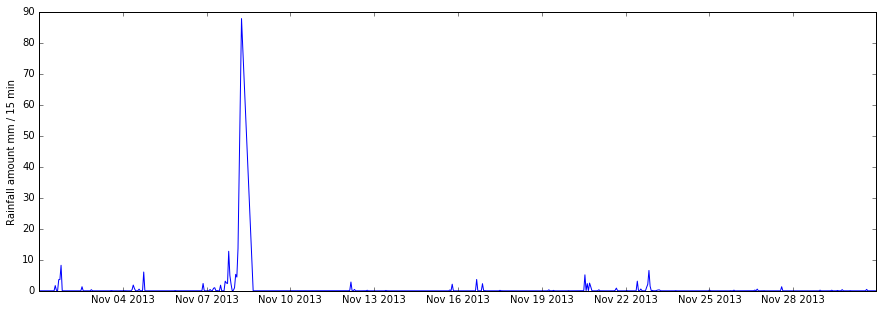

In [20]:
fig = pl.figure(figsize=(15,5))
pl.plot(df_station['timestamp'],df_station['rainfall_amount'])
pl.ylabel('Rainfall amount mm / %s min'% sampling_period)

Since the index we used in the `df` dataframe (`stationIndex`) was not a `DatetimeIndex`, `TimedeltaIndex`, or `PeriodIndex`, we have to reset the index and set it to the `timestamp` column because we want an index of type `DatetimeIndex` for resampling.

In [21]:
df_station = df_station.reset_index().set_index('timestamp')

Now the can we do the resampling. Make sure to select only the column in `df_station` you want to resample, otherwise it will apply the calculation (in this case `sum`) to all columns, even to columns where the operation does not apply (i.e. air pressure).

In [22]:
df_station_daily_rain = df_station['rainfall_amount'].resample('D').sum()

In [23]:
df_station_daily_rain.head()

timestamp
2013-11-01    17.309999
2013-11-02     1.670000
2013-11-03     0.090000
2013-11-04     9.700000
2013-11-05     0.080000
Freq: D, Name: rainfall_amount, dtype: float32

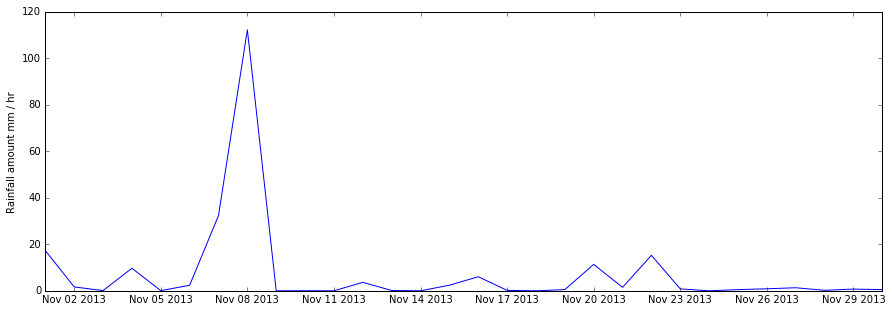

In [24]:
fig = pl.figure(figsize=(15,5))
pl.plot(df_station_daily_rain.index,df_station_daily_rain.values)
pl.ylabel('Rainfall amount mm / hr')